# Scrape Data From Reddit Pushshift

In [5]:
from Reddit_Loader import Loader
import datetime
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

In [8]:
# Set Start and End Date
START = "01/01/2020"
END = datetime.datetime.now().strftime("%d/%m/%Y") #today -> was until October 26th

In [13]:
# Load data from Pushshift and store it as a dataframe
l = Loader("gme", START, END, "wallstreetbets")
submissions = l.load_submissions()

Response cache key: 29983c8c40dd541667743b8ea5bd1315


Not all PushShift shards are active. Query results may be incomplete.


179167 result(s) available in Pushshift


Not all PushShift shards are active. Query results may be incomplete.


Total:: Success Rate: 80.71% - Requests: 2649 - Batches: 266 - Items Remaining: 354


Not all PushShift shards are active. Query results may be incomplete.


354 result(s) not found in Pushshift
Retrieved 178813 submissions from Pushshift.


In [15]:
# Save as csv
submissions.to_csv('./data/submissions.csv', encoding='utf-8', index=False)

In [14]:
# Save dataframe as pickle
submissions.to_pickle("./data/submissions.pkl")

In [27]:
submissions = pd.read_pickle("./data/submissions.pkl")

# Data Exploration

In [5]:
# All the available columns in the submissions dataframe
for element in submissions:
    print(element, end = ", ")

all_awardings, allow_live_comments, author, author_flair_css_class, author_flair_richtext, author_flair_text, author_flair_type, author_fullname, author_patreon_flair, author_premium, awarders, can_mod_post, contest_mode, created_utc, domain, full_link, gildings, id, is_crosspostable, is_meta, is_original_content, is_reddit_media_domain, is_robot_indexable, is_self, is_video, link_flair_background_color, link_flair_css_class, link_flair_richtext, link_flair_template_id, link_flair_text, link_flair_text_color, link_flair_type, locked, media_only, no_follow, num_comments, num_crossposts, over_18, parent_whitelist_status, permalink, pinned, pwls, retrieved_on, score, selftext, send_replies, spoiler, stickied, subreddit, subreddit_id, subreddit_subscribers, subreddit_type, suggested_sort, thumbnail, title, total_awards_received, treatment_tags, upvote_ratio, url, whitelist_status, wls, post_hint, preview, removed_by_category, is_gallery, thumbnail_height, thumbnail_width, url_overridden_by

In [6]:
l = ("all_awardings",
"allow_live_comments",
"author",
"author_flair_css_class",
"author_flair_richtext",
"author_flair_text",
"author_flair_type",
"author_fullname",
"author_patreon_flair",
"author_premium",
"awarders",
"can_mod_post",
"contest_mode",
"created_utc",
"domain",
"full_link",
"gildings",
"id",
"is_crosspostable",
"is_meta",
"is_original_content",
"is_reddit_media_domain",
"is_robot_indexable",
"is_self",
"is_video",
"link_flair_background_color",
"link_flair_css_class",
"link_flair_richtext",
"link_flair_template_id",
"link_flair_text",
"link_flair_text_color",
"link_flair_type",
"locked",
"media_only",
"no_follow",
"num_comments",
"num_crossposts",
"over_18",
"parent_whitelist_status",
"permalink",
"pinned",
"pwls",
"retrieved_on",
"score",
"selftext",
"send_replies",
"spoiler",
"stickied",
"subreddit",
"subreddit_id",
"subreddit_subscribers",
"subreddit_type",
"suggested_sort",
"thumbnail",
"title",
"total_awards_received",
"treatment_tags",
"upvote_ratio",
"url",
"whitelist_status",
"wls",
"post_hint",
"preview",
"removed_by_category",
"is_gallery",
"thumbnail_height",
"thumbnail_width",
"url_overridden_by_dest",
"media_metadata",
"media",
"media_embed",
"secure_media",
"secure_media_embed",
"author_flair_background_color",
"author_flair_text_color",
"edited",
"gallery_data",
"banned_by",
"author_cakeday",
"discussion_type",
"crosspost_parent",
"crosspost_parent_list",
"author_flair_template_id",
"author_is_blocked",
"is_created_from_ads_ui",
"steward_reports",
"gilded",
"distinguished",
"collections")

len(l)

89

In [7]:
# The number of Awards can be used as a proxy for the awards given
print(len(submissions["all_awardings"][44][0]["resized_icons"])) # We only count the unique awards given, not if an award has been given multiple times. May figure it out later.

# is_video can be useful to weed out posts, that do not have any content and only a video. Might still be able to perform sentiment analysis on the title.
# link_flair_text can be useful to classify content: Meme, Yolo, etc.
# subreddit_subscribers is a cool statistic
# thumbnail can be used to see if posts with a thumbnail have a bigger impact
# media refers to external links. Can probably remove all those entries

# To do:
# double check the upvote ratio, it seems to be wrong
# see how accurate removed_by_category is

5


In [28]:
# Drop unneeded columns
## allow_live_comments is Boolean
## author_flair_css_class shows the css class of the author_flair
## author_flair_richtext, author_flair_text, author_flair_type can be ignored, because the author can assign a flair to himself if he wants to
## author_fullname is just the id for the user
## author_patreon_flair, author_premium, domain, gildings, is_crosspostable, is_original_content, is_reddit_media_domain, is_robot_indexable,
## is_self, link_flair_background_color, link_flair_text_color, link_flair_css_class, link_flair_template_id, locked, media_only,
## no_follow, over_18, parent_whitelist_status, permalink, pwls, send_replies, spoiler, stickied, suggested_sort, subreddit_type, treatment_tags,
## whitelist_status, wls, preview, is_gallery, thumbnail_height, thumbnail_width, url_overridden_by_dest, media_metadata, secure_media,
## secure_media_embed, author_flair_background_color, author_flair_text_color, edited, gallery_data, banned_by do not seem to be helpful for sentiment analysis
## awarders is always empty
## can_mod_post, contest_mode, is_meta, pinned are always False
## link_flair_type, discussion_type, crosspost_parent, crosspost_parent_list, author_flair_template_id, author_is_blocked,
## is_created_from_ads_ui, steward_reports, gilded, distinguished, collections don't really say anything
## link_flair_richtext is a dictionary for for link_flair(which is not discarded)
## total_awards_received is similar to all_awardings, but not accurate
submissions = submissions.drop(columns = ["allow_live_comments", "author_flair_css_class", "author_flair_richtext", 
                            "author_flair_text", "author_flair_type", "author_fullname", "author_patreon_flair",
                            "author_premium", "domain", "awarders", "can_mod_post", "contest_mode",
                            "gildings", "is_crosspostable", "is_meta", "is_original_content", "is_reddit_media_domain",
                            "is_robot_indexable", "is_self", "link_flair_background_color", "link_flair_text_color",
                            "link_flair_type", "link_flair_css_class", "link_flair_richtext", "link_flair_template_id",
                            "locked", "media_only", "no_follow", "over_18", "parent_whitelist_status", "permalink",
                            "pinned", "pwls", "send_replies", "spoiler", "stickied", "subreddit_type", "suggested_sort",
                            "treatment_tags", "whitelist_status", "wls", "preview", "is_gallery", "thumbnail_height",
                            "thumbnail_width", "url_overridden_by_dest", "media_metadata", "secure_media", "secure_media_embed",
                            "author_flair_background_color", "author_flair_text_color", "edited", "gallery_data",
                            "banned_by", "discussion_type", "crosspost_parent", "crosspost_parent_list",
                            "author_flair_template_id", "author_is_blocked", "is_created_from_ads_ui",
                            "steward_reports", "gilded", "distinguished", "collections"])

In [29]:
print(submissions.columns)

Index(['all_awardings', 'author', 'created_utc', 'full_link', 'id', 'is_video',
       'num_comments', 'num_crossposts', 'retrieved_on', 'score', 'selftext',
       'subreddit', 'subreddit_id', 'subreddit_subscribers', 'thumbnail',
       'title', 'total_awards_received', 'upvote_ratio', 'url',
       'link_flair_text', 'post_hint', 'removed_by_category', 'author_cakeday',
       'media', 'media_embed'],
      dtype='object')


In [30]:
submissions["missing_content"] = False

In [31]:
submissions.loc[(submissions["selftext"] == "[removed]"), "missing_content"] = True

In [32]:
submissions.loc[(submissions["selftext"] == "[deleted]"), "missing_content"] = True

In [33]:
empty_content = []
for i, text in enumerate(submissions["selftext"]):
    if(len(str(text)) == 0):
        empty_content.append(i)

submissions.loc[empty_content, "missing_content"] = True


In [34]:
submissions["missing_content"].value_counts()

True     135828
False     43716
Name: missing_content, dtype: int64

In [35]:
title = "Lol I just joined today and bought GME at $90. What are yall doing?"
submissions[submissions["title"] == title][["selftext"]]

,selftext
86918,NaN


# Typical Powerlaw
Almost 80% of posts were deleted or contain no content!

In [37]:
ful_text = len(submissions[submissions["missing_content"] == False]["selftext"])
rem_text = len(submissions[submissions["missing_content"] == True]["selftext"])

# How many posts have the text not removed?
print("Posts with text:", ful_text)

# How many posts have the text "removed"?
print("Posts with removed text:", rem_text)

print("Proportion of posts with removed text:", round((rem_text)/(rem_text+ful_text),2))

Posts with text: 37966
Posts with removed text: 141578
Proportion of posts with removed text: 0.79


In [38]:
## Quite a lot of posts got removed. This is unfortunate. However, the title is still available. So I might still use the title.

# Who usually removes the post?
print("Removed by:\n", submissions[submissions["selftext"] == "[removed]"][["selftext", "removed_by_category"]].value_counts())
print("-----------------"*3)
# Were there any posts with a lot of comments that were removed?
print("Removed with x_comments:\n", submissions[submissions["selftext"] == "[removed]"][["selftext", "num_comments"]].value_counts())
print("-----------------"*3)
# Were there any posts with a high score that were removed?
print("Removed with x_comments:\n", submissions[submissions["selftext"] == "[removed]"][["selftext", "score"]].value_counts())

Removed by:
 selftext   removed_by_category
[removed]  moderator              64059
           reddit                  2201
           automod_filtered         620
           author                     1
dtype: int64
---------------------------------------------------
Removed with x_comments:
 selftext   num_comments
[removed]  0               52176
           2                8593
           1                1969
           4                 955
           3                 582
                           ...  
           192                 1
           191                 1
           190                 1
           186                 1
           64470               1
Length: 211, dtype: int64
---------------------------------------------------
Removed with x_comments:
 selftext   score
[removed]  1        60773
           2         1516
           0         1412
           3          459
           4          261
                    ...  
           180          1
           179 

In [19]:
# Put removed submissions into its own dataframe and then only use submissions that still exist.
submissions_removed = submissions[submissions["selftext"] == "[removed]"]
submissions = submissions[submissions["selftext"] != "[removed]"]

In [20]:
# Save submissions with flag to csv to do some manual analysis
submissions.to_csv('./data/test.csv', encoding='utf-8', index=False)

# Preprocess Title

source: https://realpython.com/nltk-nlp-python/

<b>Tokenizing by word:</b> Words are like the atoms of natural language. They’re the smallest unit of meaning that still makes sense on its own. Tokenizing your text by word allows you to identify words that come up particularly often. For example, if you were analyzing a group of job ads, then you might find that the word “Python” comes up often. That could suggest high demand for Python knowledge, but you’d need to look deeper to know more.

<b>Tokenizing by sentence:</b> When you tokenize by sentence, you can analyze how those words relate to one another and see more context. Are there a lot of negative words around the word “Python” because the hiring manager doesn’t like Python? Are there more terms from the domain of herpetology than the domain of software development, suggesting that you may be dealing with an entirely different kind of python than you were expecting?

# Active Learner

Step 1: Read in seed data and concatenate the title and content

In [2]:
seed = pd.read_excel("./data/annotation.xlsx", header = None, usecols = range(0, 4))

In [3]:
# Rename columns
seed = seed.rename(columns = {0 : "index", 1 : "title", 2 : "content", 3 : "sentiment"})

In [4]:
seed[["sentiment"]].value_counts()

sentiment
bullish      9357
neutral      5119
bearish      3479
dtype: int64

In [5]:
import main
submissions = pd.read_pickle("./data/submissions.pkl")
submissions = main.drop_unneeded_columns(submissions)
submissions = main.flag_records_with_no_content(submissions)

In [6]:
# Remove [removed]/[deleted] from selftext if it is missing
submissions.loc[submissions["missing_content"] == True, "selftext"] = ""

In [7]:
## Exploartory!

# Find indexes where annotation does not have the same text as the submissions df
index_mismatch = []
for value in seed["index"]:
    if seed["title"][value/10] != submissions["title"][value]:
        index_mismatch.append(value)

print(index_mismatch)

# For some reason there is one mismatch. Since it is just one out of almost 18000, it does not really matter...

[20]


In [8]:
# Concatenate Text
submissions["text"] = submissions["title"] + " " + submissions["selftext"]

In [9]:
# Drop columns
submissions = submissions.drop(columns = {"title", "selftext"})

# Add sentiment column
submissions["sentiment"] = ""

# Add known labels
for i in seed["index"]:
    submissions.loc[i, "sentiment"] = seed.loc[i/10, "sentiment"]

Step 2: Prepare Data

In [3]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
#nltk.download('wordnet')
#nltk.download()

In [11]:
def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", str(sample))

submissions["text"] = submissions["text"].apply(lambda x: remove_URL(x))

In [12]:
def remove_escape_newline(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"\n", "", str(sample))

submissions["text"] = submissions["text"].apply(lambda x: remove_escape_newline(x))

In [13]:
def remove_escape_tab(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"\t", "", str(sample))

submissions["text"] = submissions["text"].apply(lambda x: remove_escape_tab(x))

In [14]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in str(text) if i not in string.punctuation])
    return punctuationfree

#storing the puntuation free text
submissions["text"] = submissions["text"].apply(lambda x: remove_punctuation(x))

In [15]:
# lowercase
submissions["text"] = submissions["text"].str.lower()

In [16]:
def remove_some_chars(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"[“”—-]", "", str(sample))

submissions["text"] = submissions["text"].apply(lambda x: remove_some_chars(x))


In [17]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize_text(sentence):
    doc = nlp(sentence)
    lem = " ".join([token.lemma_ for token in doc])
    return lem

submissions["text"] = submissions["text"].apply(lambda x: lemmatize_text(x))

In [18]:
def remove_stopwords(l):
    new_list = []
    new_sentence = []
    for sentence in l:
        for word in sentence.split(" "): # Here we also tokenize our sentence
            if word not in nltk.corpus.stopwords.words('english') and len(word) > 0:
                new_sentence.append(word)
        new_list.append(new_sentence)
        new_sentence = []
    return new_list

submissions["text"] = remove_stopwords(list(submissions["text"]))

In [19]:
def remove_special_character(l):
    new_l = []
    for word in l:
        if word != "-" and word != "—" and word != "¿":
            new_l.append(word)
    return new_l
submissions["text"] = submissions["text"].apply(lambda x: remove_special_character(x))   

In [20]:
submissions.to_pickle("./data/cleaned_submissions.pkl")

In [10]:
data = pd.read_pickle("./data/cleaned_submissions.pkl")
# del submissions

In [5]:
def count_occurances(dic):
    one, two, three, four, five, six, seven, eight, nine = 0, 0, 0, 0, 0, 0, 0, 0, 0
    for item in dic.values():
        if item == 1:
            one = one + 1
        if item == 2:
            two = two + 1
        if item == 3:
            three = three + 1
        if item == 4:
            four = four + 1
        if item == 5:
            five = five + 1
        if item == 6:
            six = six + 1
        if item == 7:
            seven = seven + 1
        if item == 8:
            eight = eight + 1
        if item == 9:
            nine = nine + 1
    return one, two, three, four, five, six, seven, eight, nine

In [6]:
import collections
words = data['text'].tolist()
word_count = collections.Counter([x for sublist in words for x in sublist])
unique_word = len(word_count)

print("Number of unique words:", unique_word)
print("Number of = 1: ", count_occurances(word_count)[0], "-", int(round(count_occurances(word_count)[0]/unique_word, 2)*100),"%")
print("Number of = 2: ", count_occurances(word_count)[1], "-", int(round(count_occurances(word_count)[1]/unique_word, 2)*100),"%")
print("Number of = 3: ", count_occurances(word_count)[2], "-", int(round(count_occurances(word_count)[2]/unique_word, 2)*100),"%")
print("Number of = 4: ", count_occurances(word_count)[3], "-", int(round(count_occurances(word_count)[3]/unique_word, 2)*100),"%")
print("Number of = 5: ", count_occurances(word_count)[4], "-", int(round(count_occurances(word_count)[4]/unique_word, 2)*100),"%")
print("Number of = 6: ", count_occurances(word_count)[5], "-", int(round(count_occurances(word_count)[5]/unique_word, 2)*100),"%")
print("Number of = 7: ", count_occurances(word_count)[6], "-", int(round(count_occurances(word_count)[6]/unique_word, 2)*100),"%")
print("Number of = 8: ", count_occurances(word_count)[7], "-", int(round(count_occurances(word_count)[7]/unique_word, 2)*100),"%")
print("Number of = 9: ", count_occurances(word_count)[8], "-", int(round(count_occurances(word_count)[8]/unique_word, 2)*100),"%")
print("Number of > 10: ", unique_word - sum(count_occurances(word_count)), "-", int(round( ( unique_word - sum(count_occurances(word_count)) ) / unique_word, 2)*100),"%")

Number of unique words: 145292
Number of = 1:  92874 - 64 %
Number of = 2:  19064 - 13 %
Number of = 3:  7206 - 5 %
Number of = 4:  4528 - 3 %
Number of = 5:  2587 - 2 %
Number of = 6:  1949 - 1 %
Number of = 7:  1385 - 1 %
Number of = 8:  1228 - 1 %
Number of = 9:  1008 - 1 %
Number of > 10:  13463 - 9 %


In [ ]:
from modAL.models import ActiveLearner
from sklearn.svm import SVC

'''learner = ActiveLearner(estimator = SVC(), \
    X_training=)'''

In [26]:
text = data["text"]
labels = data["sentiment"]

In [27]:
indices = []
for i in range(0, len(labels), 10):
    indices.append(i)

In [28]:
text = text[indices]
labels = labels[indices]

In [30]:
text = text[:1000]
labels = labels[:1000]

/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


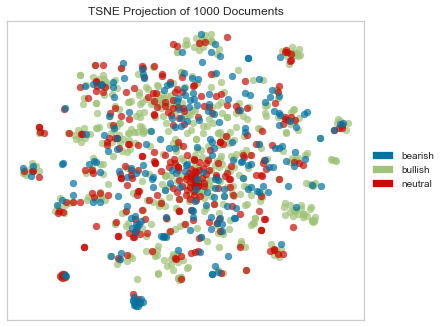

<AxesSubplot:title={'center':'TSNE Projection of 1000 Documents'}>

In [31]:
# Playing with t-sne

from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies

# Load the data and create document vectors
corpus = load_hobbies()
tfidf = TfidfVectorizer(preprocessor=' '.join, lowercase=False)

X = tfidf.fit_transform(text)
y = labels

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()